# CS166 Traffic Intersections
## Ang Li-Lian

In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt 
import scipy.stats as sts 

# Simulation Model

In [2]:
class TrafficSimulation:
    """
    Create a new traffic simulation object with a two-way street.

    Inputs:

        stop (int) The length of a red light signal for the main road.

        lag (int) The time between adding new cars
            Default: 2.

    """
    def __init__(self, stop, lag =2):
        self.road_length = 100
        self.time_step = 0
        self.lag = lag
        if stop <= 0 or stop%1!=0:
            raise ValueError("Choose a red light length as an integer more than zero")
        else:
            self.stop = stop
        
        # Store Metrics
        self.metric = []    
        self.wait = []
        self.queue = []

        # Set up traffic lights
        self.traffic_lights = np.array([15,45, 51, 61, 78, 85])
        self.red =np.arange(len(self.traffic_lights))
        
        # Set up roads
        self.roads = [Road(self, "R")] + [Road(self, "L")]
        self.states = [0]*len(self.roads)

    def intersections(self):
        # Control timing for traffic lights
        if self.time_step % self.stop==0:
            self.red = np.roll(self.red, shift=-1)
        return self.red[:3]
    
    def update(self):
        '''
        Advance one time step in the simulation.
        '''
        red = self.intersections()

        for i in range(len(self.roads)):
            self.states[i]= self.roads[i].update(red)

        # Update traffic flow history
        self.time_step += 1
        flow = [np.sum(state[state>0])/self.road_length for state in self.states]
        self.metric.append(np.mean(flow))

    def add_wait(self, wait):
        '''
        Store maximum queue length.
        '''
        self.wait += wait

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(f"Time: {self.time_step}")
        for state in self.states:
            road = np.insert(state, self.traffic_lights[::-1], np.array(["-2"]*len(self.traffic_lights)))
            print(''.join('.' if x == -1 else "T" if x ==-2 else str(x)  for x in road))

class Road:
    """
    Create a road which stores all cars on it.

    Inputs:

        sim (obj) Gives access to attributes and methods from Traffic Simulation.

        direction (str) Determines the direction of travel on the road.
            Default: "R".

    """
    def __init__(self, sim, direction = "R"):
        self.sim = sim 

        # Create an empty road: -1 means empty in this simulation
        self.road_length = self.sim.road_length
        self.state = np.full(self.road_length, -1, dtype=int)
        self.direction = direction
        
        # Set up intersections and car flow
        if direction == "L": # For opposite flow of traffic invert the road
            self.traffic_lights = self.road_length - self.sim.traffic_lights
            self.origin = np.concatenate((np.array([-1]), self.traffic_lights[::-1]))
            self.flow = np.array([0.9,0.8,0.6,0.1,0.1,0.7,0.3])
            self.destination = [0.1, 0.1,0.025, 0.025, 0.15,0.3, 0.3] 
        else:
            self.traffic_lights = self.sim.traffic_lights
            self.origin = np.concatenate((np.array([0]), self.traffic_lights))
            self.flow = np.array([0.95,0.6,0.5,0.2,0.1,0.4,0.3])
            self.destination = [0.1, 0.2, 0.05,0.025,0.125,0.2,0.3] 
 
        # Store cars on the road 
        self.cars = []
        self.junction = {tl:[] for tl in self.origin}
        self.wait = []

    def update(self, red):
        # Check for intersections with green light
        green = np.setdiff1d(self.origin, self.traffic_lights[red]) 
        
        if self.sim.time_step%self.sim.lag==0: # Buffer time between adding cars
            for i in green:
                # Cars in queue
                if self.junction[i] and self.state[i+1] ==-1:
                    self.cars.append(self.junction[i].pop(0))
                    self.wait.remove(self.cars[-1])
                    self.state[i+1]= self.cars[-1].speed
                # Cars enter based on flow 
                if np.random.random() <self.flow[np.where(self.origin ==i)]:
                    # Randomly determine destination for each car
                    destination = list(self.traffic_lights)+[self.road_length]
                    car = Car(i+1, np.random.choice(destination, p=self.destination))
                    if self.state[i+1] ==-1: # Enter after traffic light
                        self.cars.append(car)
                        self.state[i+1]= self.cars[-1].speed
                    else: # Store in queue
                        self.junction[i].append(car)
                        self.wait.append(car)                    

        # Update waiting times for cars in junction
        for car in self.wait:
            car.wait +=1
        
        # Update max queue length
        self.sim.queue.append(max([len(self.junction[d]) for d in self.junction.keys()]))
                    
        # Get the location of each car
        self.cars.sort(key=lambda x: x.pos)
        car_indexes = [car.pos for car in self.cars]

        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            return self.state

        # Get the distance from each car to the next car
        dist = np.ediff1d(
                np.concatenate((car_indexes, [car_indexes[0] + self.road_length+1])))
    
        # Update car speeds
        for c in range(len(self.cars)):
            self.cars[c].update(dist[c], self.traffic_lights[red])
        
        # If cars leave, they exit the system
        self.sim.add_wait([car.wait for car in self.cars if car.pos >= self.road_length])
        self.cars = [car for car in self.cars if car.pos <self.road_length]

        # Move cars by new speeds        
        self.state.fill(-1)
        speed = [car.speed for car in self.cars]
        self.state[[car.pos for car in self.cars]] = speed

        if self.direction == "L":
            return self.state[::-1] # Reverse direction for printing
        else:
            return self.state

In [3]:
class Car:
    """
    Create a car object that has a random speed between 1 and 5.

    Inputs:

        origin (int) Determines starting position of the car.

        destination (int) Determines which index the car will exit.

    """
    def __init__(self, origin, destination):
        self.max_speed = 5
        self.prob_slow = 0.2
        self.pos = origin
        self.wait = 0

        # Randomly set speed and destination for car
        self.speed = np.random.randint(1, self.max_speed + 1)
        self.destination = destination
        if self.destination <5:
            self.destination = 75

    def update(self, next_car, traffic_light):
        # Treat red traffic light as a car with zero velocity
        tl = np.concatenate(((traffic_light -self.pos),np.array([1000])))
        tl = np.min(tl[tl>0])
        if tl < next_car:
            next_car = tl
                
        # Acceleration
        if next_car > self.speed+1 and self.speed<self.max_speed:
            self.speed +=1
        
        # Deceleration
        elif self.speed >= next_car:
            self.speed = next_car-1
    
        # Randomization
        if np.random.random() < self.prob_slow and self.speed>0:
            self.speed -= 1
        
        # Slow down if close to exit
        if self.destination -self.pos <2 and self.speed >1:
            self.speed -=1

        self.pos +=self.speed 

        # Keep track of time in standstill
        if self.speed ==0:
            self.wait +=1

        # Exit road at turning
        if self.pos >=self.destination:
            self.pos = float("inf")

In [4]:
# Raises error if the stop length is not an integer
TrafficSimulation(3.5)

ValueError: Choose a red light length as an integer more than zero

In [5]:
# Raises error if the stop length is not more than 1
TrafficSimulation(0)

ValueError: Choose a red light length as an integer more than zero

In [6]:
# Example of simulation working. The T's stand for traffic light.
traffic = TrafficSimulation(3)
for _ in range(40):
    traffic.update()
    traffic.display()

Time: 1
...2...........T..............................T......T..........T.................T.......T...............
...............T..............................T......T..........T.................T5......T............2..
Time: 2
......3........T..............................T......T..........T.................T.......T...............
...............T..............................T......T..........T............5....T.......T.........3.....
Time: 3
.....4....4....T..............................T......T..........T.................T.......T...............
...............T..............................T......T..........T.......5.....2...T...2...T......3.....2..
Time: 4
.........4....4T..............................T......T..........T.................T.......T...............
...............T..............................T......T..........T..5........2.....T.2.....T..4.......2....
Time: 5
......5......4.T....5.........................T......T..........T.................T.......T.............

## Results and plots

In [7]:
def indiv_plot(result, title, xaxis):
    average = np.mean(result, axis=1)
    std_err = sts.sem(result, axis = 1)
    plt.plot(np.arange(2,22,2), average, label = "Mean", c="b")
    plt.plot(np.arange(2,22,2), average - 1.96 * std_err, 'k:',
            label='95% confidence interval', c="b")
    plt.plot(np.arange(2,22,2), average + 1.96 * std_err, 'k:')
    plt.xlabel("Length of Red Light")
    plt.ylabel(xaxis)
    plt.title(title)
    plt.legend()
    plt.show()

In [8]:
average_wait = []
average_flow = []
max_queue =[]

for i in np.arange(2, 22, 2):
    flow = []
    wait = []
    queue = []
    for n in range(100):
        traffic = TrafficSimulation(i)
        for _ in range(300):
            traffic.update()
        flow.append(np.mean(traffic.metric[100:]))
        wait.append(np.mean(traffic.wait[100:]))
        queue.append(np.mean(traffic.queue[100:]))
    average_flow.append(flow)
    average_wait.append(wait)
    max_queue.append(queue)


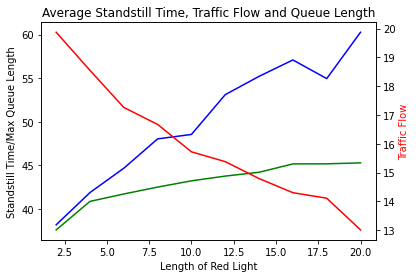

In [9]:
fig,ax = plt.subplots()

wait_mean = np.mean(average_wait, axis=1)
std_err_wait = sts.sem(average_wait, axis = 1)
ax.plot(np.arange(2,22,2), wait_mean, label = "Standstill", c="b")

queue_mean = np.mean(max_queue, axis=1)
std_err_queue = sts.sem(max_queue, axis = 1)
ax.plot(np.arange(2,22,2), queue_mean, label = "Queue Length", c="g")
ax.set_ylabel("Standstill Time/Max Queue Length") 

ax2=ax.twinx()
flow_mean = np.mean(average_flow, axis=1)*100
std_err = sts.sem(average_flow, axis = 1)*100
ax2.plot(np.arange(2,22,2), flow_mean, label = "Traffic Flow", c ="r")
ax2.set_ylabel("Traffic Flow", c= "r") 

ax.set_xlabel("Length of Red Light")
plt.title("Average Standstill Time, Traffic Flow and Queue Length")
plt.show()

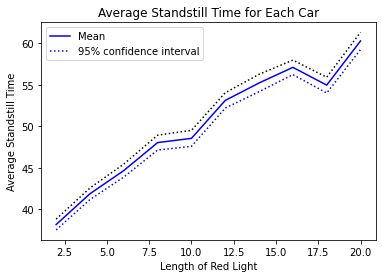

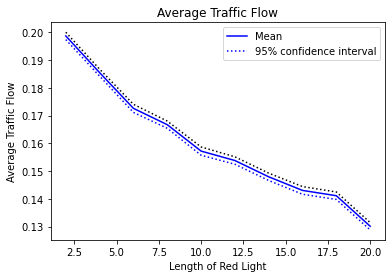

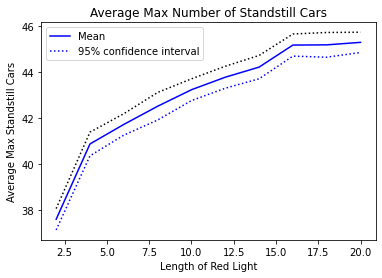

In [10]:
indiv_plot(average_wait,"Average Standstill Time for Each Car", "Average Standstill Time")
indiv_plot(average_flow,"Average Traffic Flow", "Average Traffic Flow")
indiv_plot(max_queue,"Average Max Number of Standstill Cars", "Average Max Standstill Cars")

# New Strategy

In [11]:
class TrafficStrategy(TrafficSimulation):
    def __init__(self,stop, lag = 2):
        super().__init__(stop, lag = 2)
    
    def intersections(self):
        # Control timing for traffic lights
        if self.time_step %self.stop*2 in np.arange(0, self.stop):
            return np.arange(len(self.traffic_lights))
        return []

In [12]:
# Example of simulation working. The T's stand for traffic light.
traffic_strat = TrafficStrategy(3)
for _ in range(50):
    traffic_strat.update()
    traffic_strat.display()

Time: 1
.....4.........T..............................T......T..........T.................T.......T...............
...............T..............................T......T..........T.................T.......T.........5.....
Time: 2
..........5....T..............................T......T..........T.................T.......T...............
...............T..............................T......T..........T.................T.......T.....4.........
Time: 3
......5.......4T..............................T......T..........T.................T.......T...............
...............T........................4.....T......T.....3....T...........4.....T5......T5...........2..
Time: 4
...........5..0T..............................T......T..........T.................T.......T...............
...............T....................4.........T......T.4........T......5..........T0......T0.........2....
Time: 5
..1..........20T..............................T......T..........T.................T.......T.............

## Results and Plots

In [13]:
average_wait = []
average_flow = []
max_queue =[]

for i in np.arange(2, 22, 2):
    flow = []
    wait = []
    queue = []
    for n in range(100):
        traffic = TrafficStrategy(i)
        for _ in range(300):
            traffic.update()
        flow.append(np.mean(traffic.metric[100:]))
        wait.append(np.mean(traffic.wait[100:]))
        queue.append(np.mean(traffic.queue[100:]))
    average_flow.append(flow)
    average_wait.append(wait)
    max_queue.append(queue)

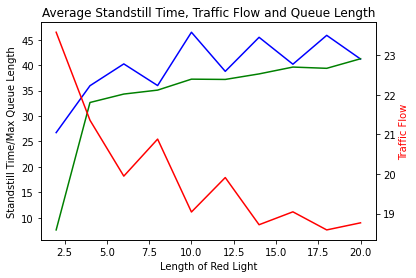

In [14]:
fig,ax = plt.subplots()

wait_mean = np.mean(average_wait, axis=1)
std_err_wait = sts.sem(average_wait, axis = 1)
ax.plot(np.arange(2,22,2), wait_mean, label = "Standstill", c="b")

queue_mean = np.mean(max_queue, axis=1)
std_err_queue = sts.sem(max_queue, axis = 1)
ax.plot(np.arange(2,22,2), queue_mean, label = "Queue Length", c="g")
ax.set_ylabel("Standstill Time/Max Queue Length") 

ax2=ax.twinx()
flow_mean = np.mean(average_flow, axis=1)*100
std_err = sts.sem(average_flow, axis = 1)*100
ax2.plot(np.arange(2,22,2), flow_mean, label = "Traffic Flow", c ="r")
ax2.set_ylabel("Traffic Flow", c= "r") 

ax.set_xlabel("Length of Red Light")
plt.title("Average Standstill Time, Traffic Flow and Queue Length")
plt.show()

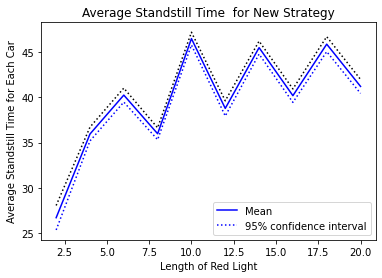

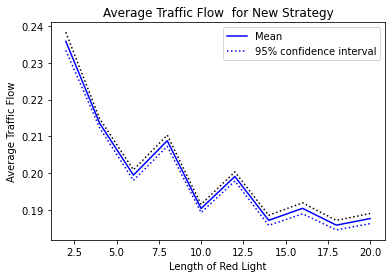

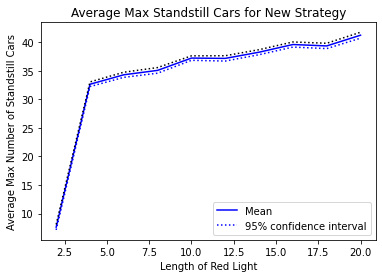

In [15]:
indiv_plot(average_wait, "Average Standstill Time  for New Strategy","Average Standstill Time for Each Car")
indiv_plot(average_flow,"Average Traffic Flow  for New Strategy", "Average Traffic Flow")
indiv_plot(max_queue, "Average Max Standstill Cars for New Strategy", "Average Max Number of Standstill Cars")